Titanic - Machine Learning from Disaster

![Titanic](wreck_titanic.jpeg)

In [104]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic-pic/wreck_titanic.jpeg
/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv



1 - Understanding problem and goal

The goal is: use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.

Data Dictionary

|Variable|Definition|Key|
|--------|----------|---|
|survival|Survival|0 = No, 1 = Yes|
|pclass|Ticket class|1 = 1st, 2 = 2nd, 3 = 3rd|
|sex|Sex| |
|Age|Age in years| |
|sibsp|# of siblings / spouses aboard the Titanic| |
|parch|# of parents / children aboard the Titanic| |
|ticket|Ticket number| |
|fare|Passenger fare| |
|cabin|Cabin number| |
|embarked|Port of Embarkation|C = Cherbourg, Q = Queenstown, S = Southampton|


Variable Notes

pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...

Sibling = brother, sister, stepbrother, stepsister

Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...

Parent = mother, father

Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

Understanding the data

- EDA (exploratory data analysis)
    - Import libraries
    - Loading data
    - Understanding the data
    - Exploring relationships
    - Feature engineering 
    

In [106]:
# Import packages for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# This lets us see all of the columns, preventing Juptyer from redacting them.
pd.set_option('display.max_columns', None)

# Import packages for data modeling
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import OneHotEncoder 
from sklearn.linear_model import LogisticRegression 
import sklearn.metrics as metrics


# This is the function that helps plot feature importance
from xgboost import plot_importance

# This module lets us save our models once we fit them.
import pickle

In [107]:
### Load data set
df_train = pd.read_csv('/kaggle/input/titanic/train.csv')
df_test = pd.read_csv('/kaggle/input/titanic/test.csv')

In [108]:
### Understanding the data

### check number shape of data
print('train', df_train.shape)
print('test', df_test.shape)

train (891, 12)
test (418, 11)


In [109]:
### Understanding the data

### Check columns and info

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


from the info one can see the missing values but this will be check with isna later

In [110]:
### Understanding the data
### Look at first 5 rows of training data
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [111]:
### Understanding the data
### Look at last 5 rows of training data
df_train.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [112]:
### Understanding the data
### Look at first 5 rows of testing data
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [113]:
### Understanding the data
### Look at last 5 rows of testing data
df_test.tail()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S
417,1309,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C


Train data goes from passengers 1 to 891 and test data from passengers 892 to 1309

This is usefull so I can concatenate the data X data (features) for doing the data cleaning and EDA and then spliting it once ready for modeling 

In [114]:
### Understanding the data

### check for missing values
df_train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

There are 177 age data fields missing, this is almost 20% of the training data.
The 687 missing values in the cabin feature account for 77% of training data so these values would need to be fill or drop the cabin column. Now one needs to explore if cabin number correlates with other features like for example passenger class. 

In [115]:
### Understanding the data

### check for duplicates 
df_train.duplicated().sum()

0

No duplicated values

In [116]:
### Understanding the data

###  descriptive analytics
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


No infinite values but hard to see only with descriptive if outliers

In [117]:
## to further analyze the cabin feature I create a cabin variable dropping the missing values
## the goal is to further analyze to determine how best to fill cabin missing values
### in other words see if correlation between cabin and class and survival

df_cabin = df_train.copy()
df_cabin = df_cabin.dropna(subset='Cabin')
df_cabin.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S


In [118]:
### check new cabin data missing values removal worked

df_cabin.isna().sum()

PassengerId     0
Survived        0
Pclass          0
Name            0
Sex             0
Age            19
SibSp           0
Parch           0
Ticket          0
Fare            0
Cabin           0
Embarked        2
dtype: int64

In [119]:
### create a new column with the first letter of cabin number
### this will help letter to see if relationship between cabin and survived
df_cabin['cab_letter'] = df_cabin['Cabin'].astype(str).str[0]

In [120]:
### Exploring relationships
### drop the first letter from cabin number
df_cabin['Cabin'] = df_cabin['Cabin'].str[1:]

In [121]:
### Exploring relationships
### check change in rows 
df_cabin.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,cab_letter
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,85,C,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,123,S,C
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,46,S,E
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,6,S,G
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,103,S,C


In [122]:
### Exploring relationships
### check unique values in cabin
df_cabin['Cabin'].unique()

array(['85', '123', '46', '6', '103', '56', '23 C25 C27', '78', '33',
       '30', '52', '28', '83', ' G73', '31', '5', '10 D12', '26', '110',
       '58 B60', '101', ' E69', '47', '86', '2', '19', '7', '49', '4',
       '32', '80', '36', '15', '93', '35', '87', '77', '67', '94', '125',
       '99', '118', '', '22 C26', '106', '65', '54', '57 B59 B63 B66',
       '34', '18', '124', '91', '40', '128', '37', '50', '82', '96 B98',
       '10', '44', '104', '111', '92', '38', '21', '12', '63', '14', '20',
       '79', '25', '73', '95', '39', '22', '70', '16', '68', '41', '9',
       '23', '48', '58', '126', '71', '51 B53 B55', ' G63', '62 C64',
       '24', '90', '45', '8', '121', '11', '3', '82 B84', '17', '102',
       '69', '42', '148'], dtype=object)

In [123]:
### Exploring relationships
### fix some rows that had more letters in the cabin (2 letters)
df_cabin.loc[75, 'cab_letter'] = df_cabin.loc[75, 'cab_letter'] + 'G'
df_cabin.loc[715, 'cab_letter'] = df_cabin.loc[715, 'cab_letter'] + 'G'
df_cabin[df_cabin['Cabin']==' G73']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,cab_letter
75,76,0,3,"Moen, Mr. Sigurd Hansen",male,25.0,0,0,348123,7.65,G73,S,FG
715,716,0,3,"Soholt, Mr. Peter Andreas Lauritz Andersen",male,19.0,0,0,348124,7.65,G73,S,FG


In [124]:
### Exploring relationships
### fix some rows that had more letters in the cabin (2 letters)
df_cabin['Cabin'] = df_cabin['Cabin'].astype(str)

In [125]:
### Exploring relationships
### check again cabin unique values to review changes
df_cabin['Cabin'].unique()

array(['85', '123', '46', '6', '103', '56', '23 C25 C27', '78', '33',
       '30', '52', '28', '83', ' G73', '31', '5', '10 D12', '26', '110',
       '58 B60', '101', ' E69', '47', '86', '2', '19', '7', '49', '4',
       '32', '80', '36', '15', '93', '35', '87', '77', '67', '94', '125',
       '99', '118', '', '22 C26', '106', '65', '54', '57 B59 B63 B66',
       '34', '18', '124', '91', '40', '128', '37', '50', '82', '96 B98',
       '10', '44', '104', '111', '92', '38', '21', '12', '63', '14', '20',
       '79', '25', '73', '95', '39', '22', '70', '16', '68', '41', '9',
       '23', '48', '58', '126', '71', '51 B53 B55', ' G63', '62 C64',
       '24', '90', '45', '8', '121', '11', '3', '82 B84', '17', '102',
       '69', '42', '148'], dtype=object)

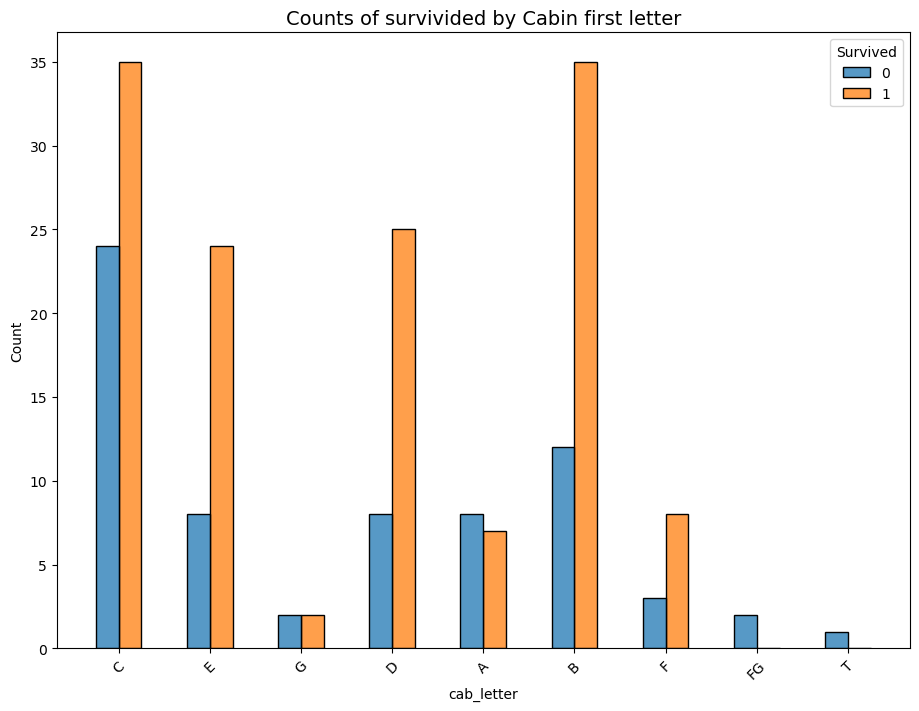

In [126]:
### Exploring relationships
# Create stacked histogram to compare cabin distribution of passengers who survived
plt.figure(figsize=(11,8))
sns.histplot(data=df_cabin, x='cab_letter', hue='Survived', discrete=1, 
             hue_order=[0, 1], multiple='dodge', shrink=.5)
plt.xticks(rotation=45)
plt.title('Counts of survivided by Cabin first letter', fontsize=14);

Most survivors were on cabins B, C, D & E
However as mentioned earlier 77% of cabin data values are missing and could be difficult to predict the starting letter for missing values
Perhaps another field as Pclass or fare could be a predictor of survival rate and in that case droping the cabin column due to its considerable amount of missing data could be the best

In [127]:
### Exploring relationships
### group to see relationsip Pclass related to cabin
df_cabin.groupby('cab_letter')['Pclass'].value_counts().sort_values(ascending=False)


cab_letter  Pclass
C           1         59
B           1         47
D           1         29
E           1         25
A           1         15
F           2          8
D           2          4
E           2          4
G           3          4
E           3          3
F           3          3
FG          3          2
T           1          1
Name: Pclass, dtype: int64

Most survived people were on cabins that started with leters B, C, D and E

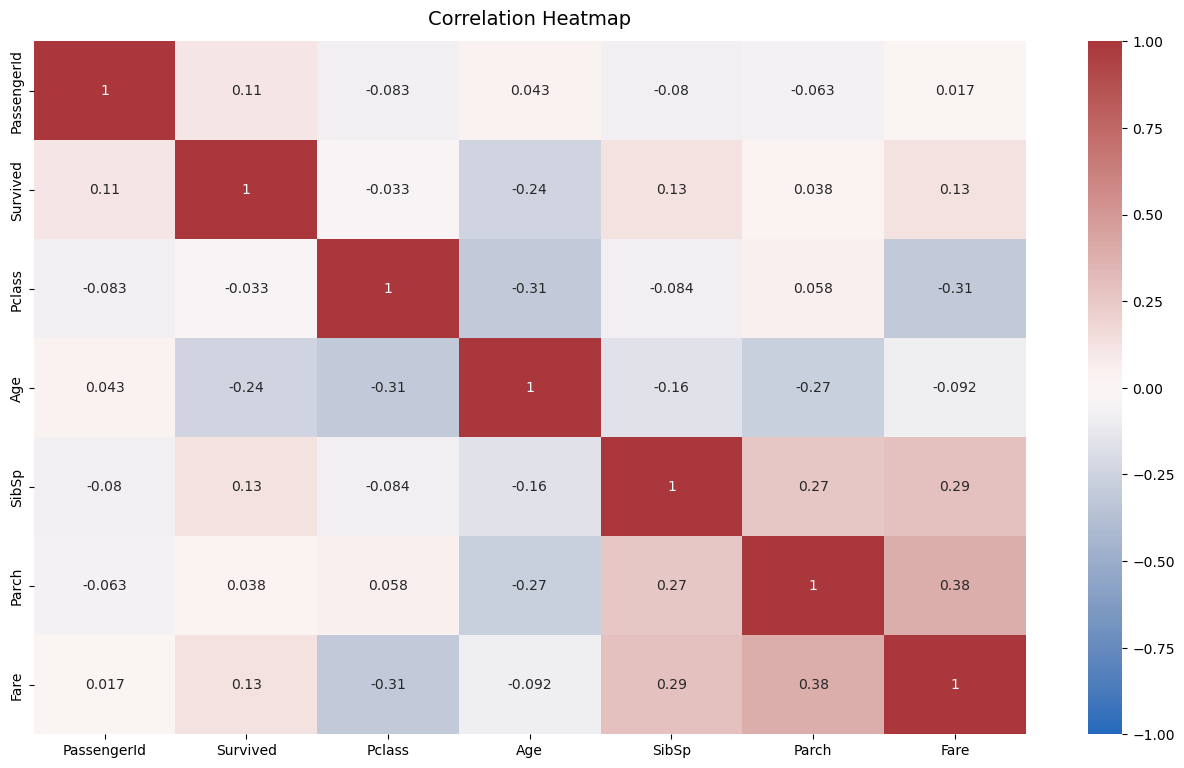

In [128]:
### Exploring relationships
# Plot a correlation heatmap (this heat map excludes the cabin missing values)
plt.figure(figsize=(16, 9))
heatmap = sns.heatmap(df_cabin.corr(numeric_only=True), vmin=-1, vmax=1, annot=True, cmap=sns.color_palette("vlag", as_cmap=True))
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=12);


There is a negative correlation survival rate and age and positive correlation survival rate and passengerID, SibSp and fare

Important to note this data is excluding cabin missing values so not definitive for analysis

In [129]:
### Exploring relationships
## analyzing separetly the age 
df_age = df_train.copy()

In [130]:
### Exploring relationships
## analyzing separetly the age 
## drop age missing values
df_age = df_age.dropna(subset='Age')

In [131]:
### Exploring relationships
## analyzing separetly the age 
df_age.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  714 non-null    int64  
 1   Survived     714 non-null    int64  
 2   Pclass       714 non-null    int64  
 3   Name         714 non-null    object 
 4   Sex          714 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        714 non-null    int64  
 7   Parch        714 non-null    int64  
 8   Ticket       714 non-null    object 
 9   Fare         714 non-null    float64
 10  Cabin        185 non-null    object 
 11  Embarked     712 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 72.5+ KB


In [132]:
### Exploring relationships
## analyzing separetly the age 
df_age['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

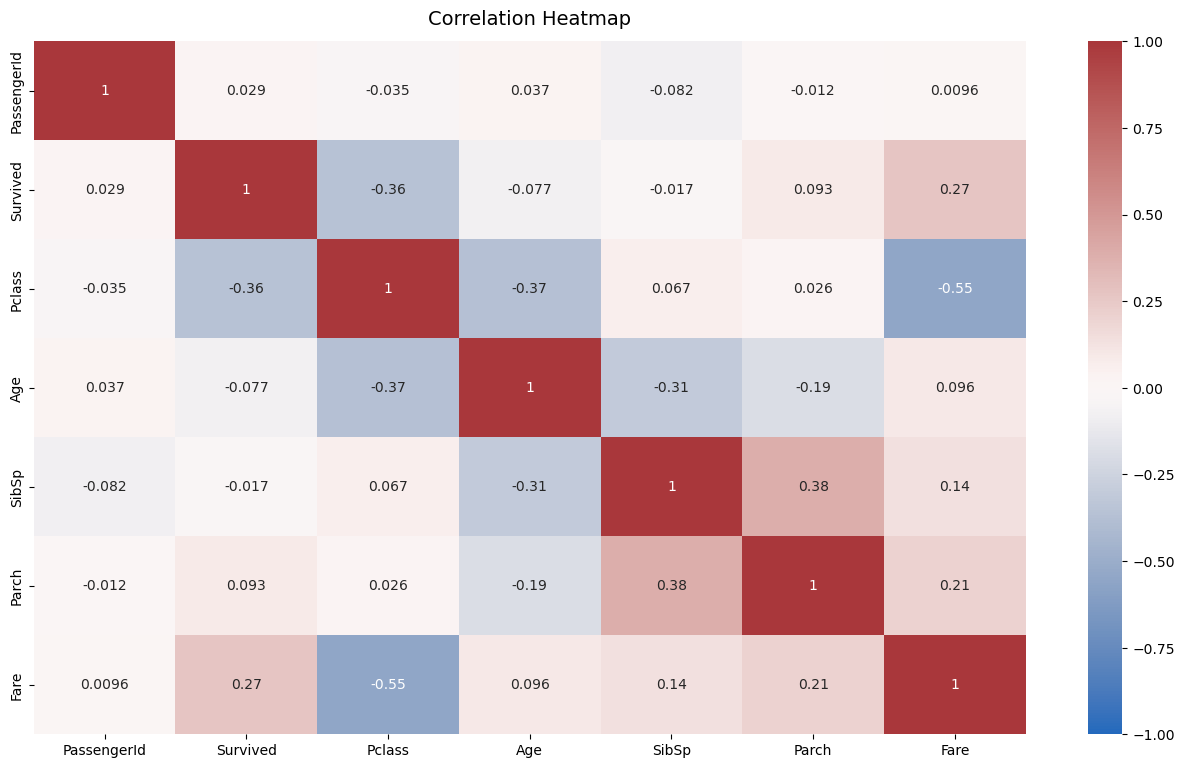

In [133]:
### Exploring relationships
## analyzing separetly the age 
# Plot a correlation heatmap
plt.figure(figsize=(16, 9))
heatmap = sns.heatmap(df_age.corr(numeric_only=True), vmin=-1, vmax=1, annot=True, cmap=sns.color_palette("vlag", as_cmap=True))
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=12);

Now that only 17% of rows were removed (age missing values removed), this heat map looks different than the one with the cabin missing values removed, of course cabin had 77% values removed which is significant

Now we can see there is a strong negative correlation between survival rate and Pclass, in other words as the class increases to second and third class the survival rate decreases which might be expected

The is a strong positive correlation between survival rate and fare meaning that as fare ticket increases the survival rate increases which is kind of expected also

No significant correlation with survival rate and age thus it might be save to fill age values

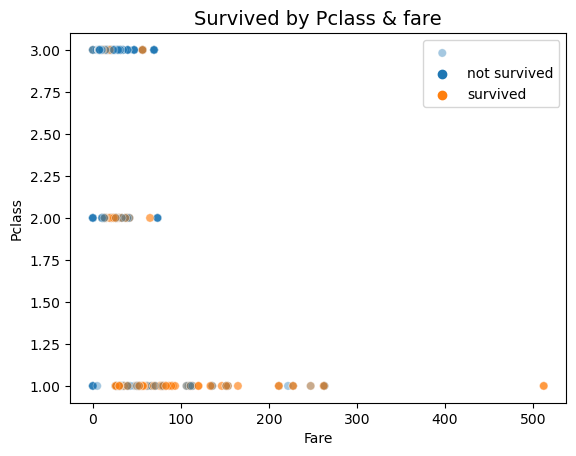

In [134]:
### Exploring relationships
## based on corr heat map is good to further check fare and pclass relationshipsplt.figure(figsize=(16, 9))
sns.scatterplot(data=df_train, x='Fare', y='Pclass', hue='Survived', alpha=0.4)
plt.legend(labels=['', 'not survived', 'survived'])
plt.title('Survived by Pclass & fare', fontsize='14');

As already found earlier, first class and higher fare had greater survival rate

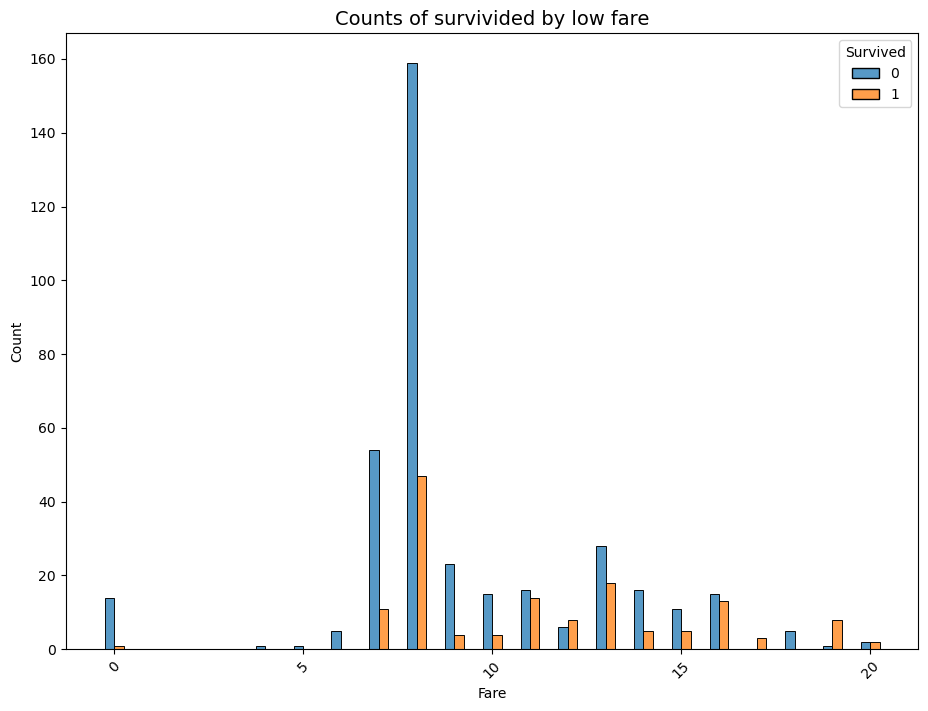

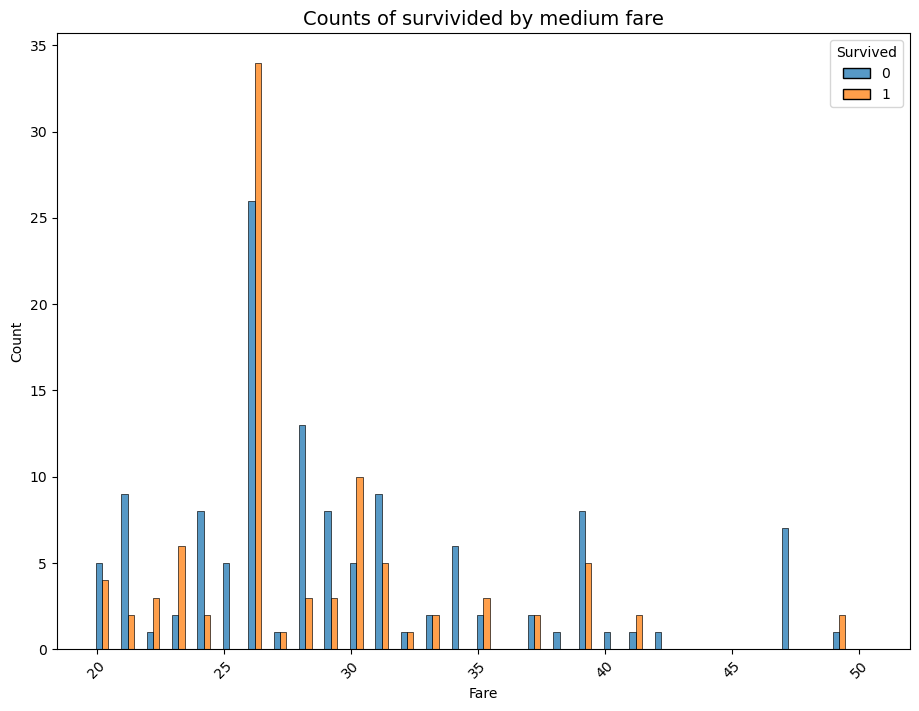

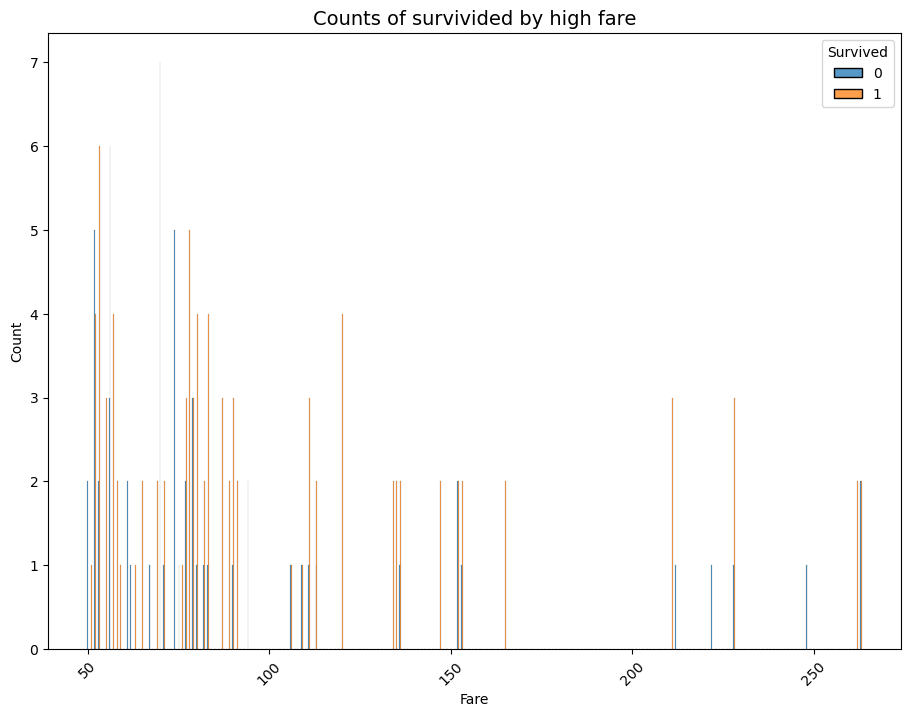

In [135]:
# Create a plot as needed 

fare_low = df_train[df_train['Fare'] <= 20]

fare_med = df_train[(df_train['Fare'] > 20) & (df_train['Fare'] < 50)]

fare_high = df_train[(df_train['Fare'] >=50) & (df_train['Fare'] < 300)]

plt.figure(figsize=(11,8))
sns.histplot(data=fare_low, x='Fare', hue='Survived', discrete=1, 
             hue_order=[0, 1], multiple='dodge', shrink=.5)
plt.xticks(rotation=45)
plt.title('Counts of survivided by low fare', fontsize=14);

plt.figure(figsize=(11,8))
sns.histplot(data=fare_med, x='Fare', hue='Survived', discrete=1, 
             hue_order=[0, 1], multiple='dodge', shrink=.5)
plt.xticks(rotation=45)
plt.title('Counts of survivided by medium fare', fontsize=14);

plt.figure(figsize=(11,8))
sns.histplot(data=fare_high, x='Fare', hue='Survived', discrete=1, 
             hue_order=[0, 1], multiple='dodge', shrink=.5)
plt.xticks(rotation=45)
plt.title('Counts of survivided by high fare', fontsize=14);

In [136]:
### continue to explore relationships fare and survival rate
print('survived fare 0-20=', fare_low['Survived'].value_counts(normalize=True)*100)
print()
print('survived fare 20-50=', fare_med['Survived'].value_counts(normalize=True)*100)
print()
print('survived fare >50=', fare_high['Survived'].value_counts(normalize=True)*100)

survived fare 0-20= 0    72.23301
1    27.76699
Name: Survived, dtype: float64

survived fare 20-50= 0    58.139535
1    41.860465
Name: Survived, dtype: float64

survived fare >50= 1    67.088608
0    32.911392
Name: Survived, dtype: float64


As seen only 28% of low fare (defines as 0-20) survived, whereas 42% of med fare (20-50) survived, interesting that high fare (>50) survived only 33%

In [137]:
### crelathionship Pclass and survival rate

df_train.groupby('Pclass')['Survived'].sum().sort_values(ascending=False)

Pclass
1    136
3    119
2     87
Name: Survived, dtype: int64

As found before and expected more survivals were from first class, interesting though thand third class survived more thand second class

Now let's make a copy of train data to start dealing with missing values now that we understand better the data

In [138]:
### copy train original data and call it X which are the features
X_train_original = df_train.copy()

In [139]:
### y_original, which is the target variable (survived)
y_train_original = df_train.copy()
y_train_original = y_train_original['Survived']

In [140]:
### from the X drop the target variable
X_train_original = X_train_original.drop('Survived', axis=1)

In [141]:
### check X feature variables
X_train_original.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [142]:
### now create a X test data copying test original data
X_test_original = df_test.copy()

In [143]:
### check x test data
X_test_original

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


X_train and X_test looks same format so we can concatenate and create and X_total so we only do one cleaning and one missing values fix

In [144]:
### concat X_train and X_test
X_total = pd.concat([X_train_original, X_test_original])

We noticed from EDA that there is a relationship between cabin first letter and survived but there is so many (77%) cabin values missing that would be hard to redict

Also from correlationship heat maps it seems fare and pclass are good predictors so I'll go ahead and remove the cabin column

In [145]:
### remove cabin column
X_total = X_total.drop('Cabin', axis=1)

In [146]:
### check data to see how change worked
X_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Pclass       1309 non-null   int64  
 2   Name         1309 non-null   object 
 3   Sex          1309 non-null   object 
 4   Age          1046 non-null   float64
 5   SibSp        1309 non-null   int64  
 6   Parch        1309 non-null   int64  
 7   Ticket       1309 non-null   object 
 8   Fare         1308 non-null   float64
 9   Embarked     1307 non-null   object 
dtypes: float64(2), int64(4), object(4)
memory usage: 112.5+ KB


Cabin column removal worked

Now we have to deal with age missing values, from the correlationship heat map there wasn't a strong relationship between age and survived target so I proceed filling the age with and average of age

There is only one fare missing value so it'll be fill with the mean as well

There are two embarked missing values, as this is categorical I will do a forward filling to fill missing values plus it is likely that the data would have ports were people embarked close to each other

In [147]:
### fill age missing values with the mean age
X_total['Age'] = X_total['Age'].fillna(X_total['Age'].mean())

In [148]:
### fill fare missing values with the mean fare
X_total['Fare'] = X_total['Fare'].fillna(X_total['Fare'].mean())

In [149]:
### fill emabrked missing values using forward filling
X_total['Embarked'] = X_total['Embarked'].ffill()

In [150]:
### see how changes worked

X_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Pclass       1309 non-null   int64  
 2   Name         1309 non-null   object 
 3   Sex          1309 non-null   object 
 4   Age          1309 non-null   float64
 5   SibSp        1309 non-null   int64  
 6   Parch        1309 non-null   int64  
 7   Ticket       1309 non-null   object 
 8   Fare         1309 non-null   float64
 9   Embarked     1309 non-null   object 
dtypes: float64(2), int64(4), object(4)
memory usage: 112.5+ KB


In [151]:
### check again missing values
X_total.isna().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

No missing values confirmed

In [152]:
### check first rows of data
X_total.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


Name and ticket number doesn't seem to be good predictors for our models so they will be dropped

In [153]:
### drop name and ticket columns
X= X_total.drop(['Name', 'Ticket'], axis=1)

In [154]:
### check rows to confirm changes
X.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,3,male,22.0,1,0,7.2500,S
1,2,1,female,38.0,1,0,71.2833,C
2,3,3,female,26.0,0,0,7.9250,S
3,4,1,female,35.0,1,0,53.1000,S
4,5,3,male,35.0,0,0,8.0500,S


Sex and Embarked needs to be converted to numerical for analysis

In [155]:
### conver sex and embarked features to numerical
X = pd.get_dummies(X,columns=['Sex','Embarked'], drop_first=True)

In [156]:
### check changes
X.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,1,3,22.0,1,0,7.2500,1,0,1
1,2,1,38.0,1,0,71.2833,0,0,0
2,3,3,26.0,0,0,7.9250,0,0,1
3,4,1,35.0,1,0,53.1000,0,0,1
4,5,3,35.0,0,0,8.0500,1,0,1


Changes worked well now check data types to ensure all numerical

In [157]:
### check data types
X.dtypes

PassengerId      int64
Pclass           int64
Age            float64
SibSp            int64
Parch            int64
Fare           float64
Sex_male         uint8
Embarked_Q       uint8
Embarked_S       uint8
dtype: object

Confirmed all X features numerical

In [158]:
### reset index
X.reset_index()

,index,PassengerId,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,0,1,3,22.000000,1,0,7.2500,1,0,1
1,1,2,1,38.000000,1,0,71.2833,0,0,0
2,2,3,3,26.000000,0,0,7.9250,0,0,1
3,3,4,1,35.000000,1,0,53.1000,0,0,1
4,4,5,3,35.000000,0,0,8.0500,1,0,1
...,...,...,...,...,...,...,...,...,...,...
1304,413,1305,3,29.881138,0,0,8.0500,1,0,1
1305,414,1306,1,39.000000,0,0,108.9000,0,0,0
1306,415,1307,3,38.500000,0,0,7.2500,1,0,1
1307,416,1308,3,29.881138,0,0,8.0500,1,0,1


Now that data is numerical, no missing or duplicate values we can do some boxplots just to understand outliers

Some models like ramdom forest and XGB work ok with outliers but just to better understand the cleaned data

<Axes: xlabel='Pclass'>

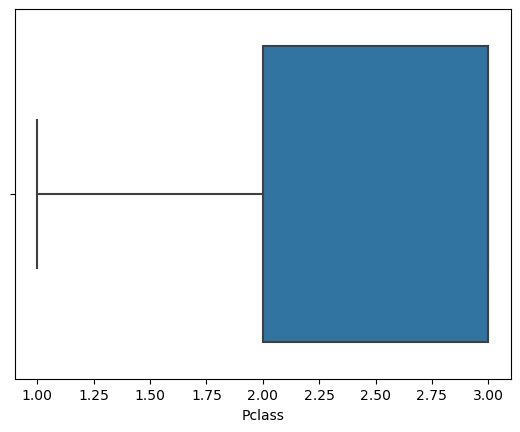

In [159]:
### pclass boxplot
sns.boxplot(x=X['Pclass'])

No outliers of course only 3 clasess, 1, 2 and 3

<Axes: xlabel='Age'>

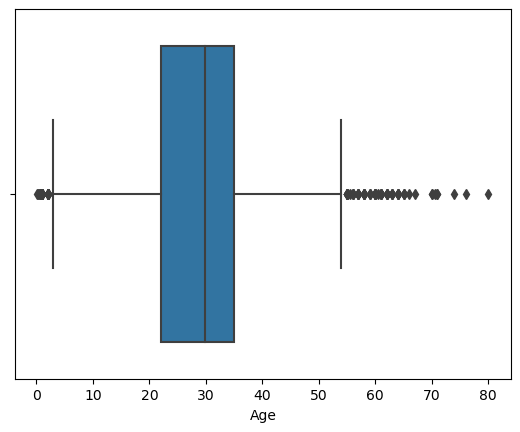

In [160]:
### age boxplot
sns.boxplot(x=X['Age'])

We can see some outliers and noticed 25 to 75% of age bewteen around 20 and 35 years and around above 55 years are outliers, also around below 2 years were outliers

<Axes: xlabel='Fare'>

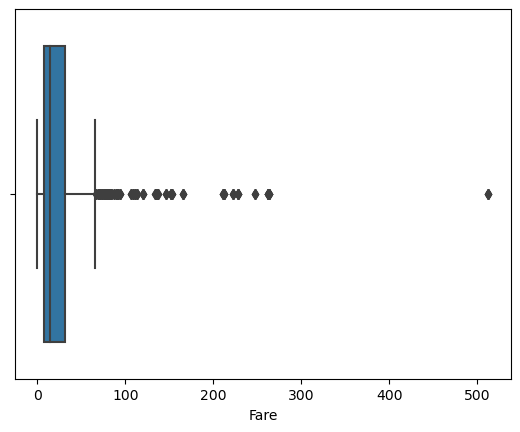

In [161]:
### fare boxplot
sns.boxplot(x=X['Fare'])

Significant outliers in the fare, around above 90 fare value are outliers

Outlier conclusion, some in age and in fare so for a logistic regression would be better to drop them but as were doing also randon forest and XGB I won't drop them 

Now I'll split again the X data into train and test as it was originally

In [162]:
### splitting the train and test data as originally 
X_test = X.iloc[891:]
X_tr = X.iloc[:891]

In [163]:
## print X train and test data to confirm changes
print(X_test.shape)
print()
print(X_tr.shape)

(418, 9)

(891, 9)


In [164]:
### check target variable shape
y_train_original.shape

(891,)

For this model I will split the training data into training and validating data

So the models will be trained and then checked with the validation data, the winner on the validation data will be tested with the test data

In [165]:
### split train data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_train_original, 
                                                  stratify=y_train_original, test_size=0.25, random_state=42)

In [166]:
#### count the train, validation and test data
for x in [X_train, X_val, X_test]:
    print(len(x))

668
223
418


In [167]:
### calculate what percentage is train, validation and test data

X_train_count = 100*668/(668+223+418)
X_val_count = 100*223/(668+223+418)
X_test_count = 100*418/(668+223+418)
print('X_train % =', round(X_train_count, 1))
print('X_valid % =', round(X_val_count, 1))
print('X_test  % =', round(X_test_count, 1))

X_train % = 51.0
X_valid % = 17.0
X_test  % = 31.9


There are multiple options for modeling:

Logistic Regression:

    Outlier sensitivity: High
    Description: Outliers can significantly skew model parameters. Pre-processing to handle outliers is often recommended.

XGBoost:

    Outlier sensitivity: Moderate
    Description: Generally robust to outliers in features due to tree-based structure, but outliers in the target variable can impact the model's performance.

Random Forest:

    Outlier sensitivity: Low
    Description: Robust to outliers in both features and target variable due to tree-based structure and independent training of trees.

K-Nearest Neighbors (KNN):

    Outlier sensitivity: High
    Description: Sensitive to outliers as predictions are based on proximity to nearest neighbors. Outliers can cause incorrect classifications or predictions.

Support Vector Machines (SVM):

    Outlier sensitivity: Low to Moderate
    Description: Generally robust to outliers, especially in classification tasks. However, sensitivity can increase in regression tasks or when using alternative loss functions.


Based on this and the fact that I don't want to have multiple data (with outliers and without outliers), I will work with Random forest, XGB and SVM, and as mentioned pick the winner on the validation data

In [168]:
### Check class imbalance
y_train.value_counts(normalize=True)*100

0    61.676647
1    38.323353
Name: Survived, dtype: float64

The target variable has no significant imbalance


Random Forest Model

I'll use grid search to cross validate with trining data and look for best parameters to use then the best parameters on validation data

I'll refit the model based on recall for balance between precision and accuracy


In [169]:
# 1. Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=42, class_weight='balanced')

# 2. Create a dictionary of hyperparameters to tune
cv_params = {'max_depth' : [10, 50, 100],
             'min_samples_leaf' : [1, 2, 5, 10],
             'min_samples_split' : [2, 5, 10],
             'max_features' : ["sqrt"],
             'max_samples' : [0.5, 0.9]}

# 3. Define a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# 4. Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='recall')

In [170]:
### fit the random forrest cross validated model
rf_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             param_grid={'max_depth': [10, 50, 100], 'max_features': ['sqrt'],
                         'max_samples': [0.5, 0.9],
                         'min_samples_leaf': [1, 2, 5, 10],
                         'min_samples_split': [2, 5, 10]},
             refit='recall', scoring={'accuracy', 'recall', 'precision', 'f1'})

In [171]:
# Examine random forest best score
rf_cv.best_score_

0.7813725490196077

In [172]:
# Examine best hyperparameter combo
rf_cv.best_params_

{'max_depth': 10,
 'max_features': 'sqrt',
 'max_samples': 0.9,
 'min_samples_leaf': 10,
 'min_samples_split': 2}

In [173]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, or accuracy

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy',
                   }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create table of results
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          },
                         )

    return table

In [174]:
results = make_results('RF cv', rf_cv, 'recall')
results

,model,precision,recall,F1,accuracy
0,RF cv,0.717867,0.781373,0.748087,0.797935


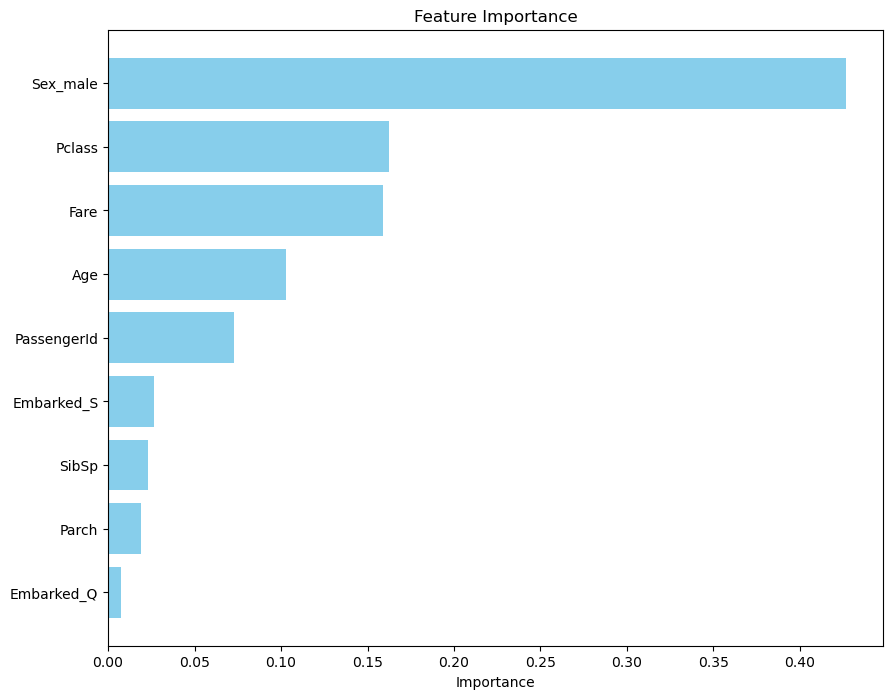

In [180]:
# Get feature importances
importances = rf_cv.best_estimator_.feature_importances_

# Get the feature names
features = X_train.columns

# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Features': features, 'Importance': importances})

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10,8))
plt.barh(importance_df['Features'], importance_df['Importance'], color='skyblue')
plt.xlabel("Importance")
plt.title("Feature Importance")
plt.gca().invert_yaxis()
plt.show()

XGB model with cross validation

In [175]:
# 1. Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=42)

# 2. Create a dictionary of hyperparameters to tune
cv_params = {
    'max_depth': [4, 6, 8, 12, 15],
    'min_child_weight': [1, 3, 5],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300, 500]
}

# 3. Define a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# 4. Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=4, refit='recall')

In [176]:
%%time
xgb_cv.fit(X_train, y_train)

CPU times: user 6min 57s, sys: 26.2 s, total: 7min 23s
Wall time: 3min 48s


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.2],
                         'max_depth': [4, 6, 8, 12, 15],
                         'min_child_weight': [1, 3, 5],
                         'n_estimators': [100, 200, 300, 500]},
             refit='recall', scoring={'accuracy', 'recall', 'precision', 'f1'})

In [177]:
# Examine best xgb score
xgb_cv.best_score_

0.7265625

In [178]:
# Examine best parameters
xgb_cv.best_params_

{'learning_rate': 0.2,
 'max_depth': 4,
 'min_child_weight': 1,
 'n_estimators': 100}

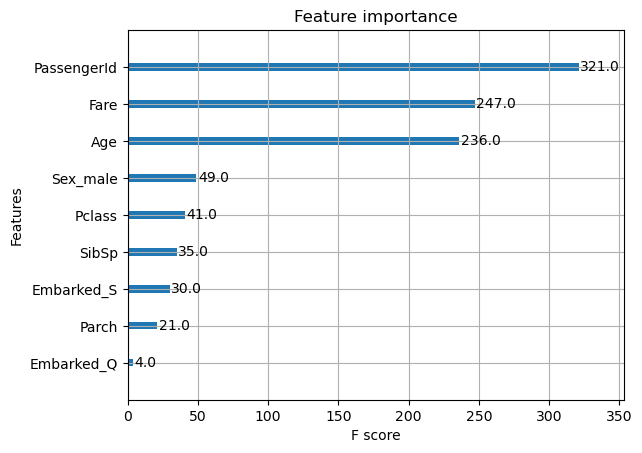

In [179]:
plot_importance(xgb_cv.best_estimator_);

In [182]:
xgb_cv_scores = make_results('XGB cv', xgb_cv, 'recall')
results = pd.concat([results, xgb_cv_scores], axis=0)


In [183]:
results

,model,precision,recall,F1,accuracy
0,RF cv,0.717867,0.781373,0.748087,0.797935
0,XGB cv,0.818429,0.726562,0.767824,0.832335


Best predictors are fare, age, sex

In [184]:
results = results.sort_values('recall', ascending=False)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.717867,0.781373,0.748087,0.797935
0,XGB cv,0.818429,0.726562,0.767824,0.832335



Based on results from the training I'll use the best estimator on validation set now


In [185]:
# Use random forest model to predict on validation data
rf_val_preds = rf_cv.best_estimator_.predict(X_val)

In [186]:
def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.

    In:
        model_name (string): Your choice: how the model will be named in the output table
        preds: numpy array of test predictions
        y_test_data: numpy array of y_test data

    Out:
        table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy]
                          })

    return table

In [187]:
# Get validation scores for RF model
rf_val_scores = get_test_scores('RF val', rf_val_preds, y_val)

# Append to the results table
results = pd.concat([results, rf_val_scores], axis=0)

In [188]:
results

,model,precision,recall,F1,accuracy
0,RF cv,0.717867,0.781373,0.748087,0.797935
0,XGB cv,0.818429,0.726562,0.767824,0.832335
0,RF val,0.706522,0.755814,0.730337,0.784753


In [189]:
# Use XGBoost model to predict on validation data
xgb_val_preds = xgb_cv.best_estimator_.predict(X_val)

# Get validation scores for XGBoost model
xgb_val_scores = get_test_scores('XGB val', xgb_val_preds, y_val)

# Append to the results table
results = pd.concat([results, xgb_val_scores], axis=0)

In [192]:
results = results.sort_values('recall', ascending=False)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.717867,0.781373,0.748087,0.797935
0,RF val,0.706522,0.755814,0.730337,0.784753
0,XGB cv,0.818429,0.726562,0.767824,0.832335
0,XGB val,0.767123,0.651163,0.704403,0.789238


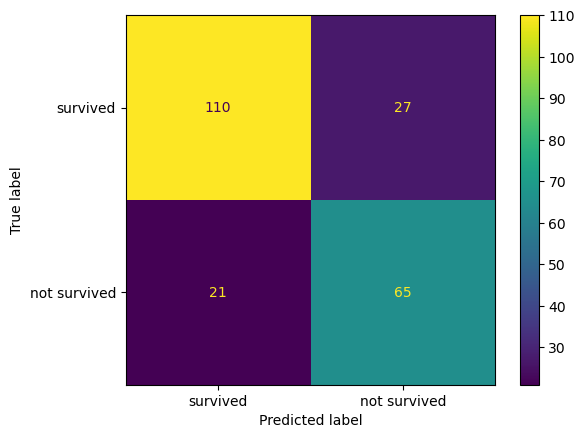

In [202]:
# Generate array of values for confusion matrix
cm = confusion_matrix(y_val, rf_val_preds, labels=rf_cv.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['survived', 'not survived'])
disp.plot();

Use champion model to predict on test data
Now, use the champion model to predict on the test dataset. This is to give a final indication of how you should expect the model to perform on new future data, should you decide to use the model.

In [191]:
### based on training and validation results use RF on test data to predict target variable
rf_test_preds = rf_cv.best_estimator_.predict(X_test)

In [194]:
### add predictions to X_test data by creating a RF column wiht the predictions
X_test = X_test.copy()
X_test.loc[:, 'Survived'] = rf_test_preds

In [195]:
### check X_test to confirm prediction column is present
X_test.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,Survived
0,892,3,34.5,0,0,7.8292,1,1,0,0
1,893,3,47.0,1,0,7.0000,0,0,1,0
2,894,2,62.0,0,0,9.6875,1,1,0,0
3,895,3,27.0,0,0,8.6625,1,0,1,0
4,896,3,22.0,1,1,12.2875,0,0,1,0


In [196]:
### create copy of X_test with predictions
df_result = X_test.copy()

In [197]:
### make df_results only two columns of interest for competition
df_result = df_result[['PassengerId', 'Survived']]

In [198]:
### check new data set few rows to confirm good
df_result.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [199]:
### count rows to confirm what expected from competition and original dataset
df_result['Survived'].value_counts()

0    241
1    177
Name: Survived, dtype: int64

In [201]:
df_result.to_csv('df_result2.csv')

This concludes exercise